In [621]:
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
%matplotlib inline
import requests
import urllib
import os
import shutil
import pickle
import time
import pandas as pd
from sklearn.utils import shuffle
import sklearn as sk
from sklearn import neural_network, linear_model, ensemble
from scipy import stats
import pandas_datareader as pdr

## Helper Functions

In [792]:
def zscore(x):
    return (x - np.nanmean(x)) / np.std(x)

def beginning_of_month(date):
    if date.is_month_start: return date
    else: return date + pd.datetools.MonthBegin(n=-1)
    
def end_of_month(date):
    return date + pd.offsets.MonthEnd(0) 


def increment_months(date, m):
    """
    Returns date incremented by m months
    """
    return date + relativedelta(months=m)

def decrement_months(date, m):
    return increment_months(date, -m)

def train_model(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    print("Train Accuracy: {0}".format(model.score(train_data, train_labels)))
    print("Test Accuracy: {0}".format(model.score(test_data, test_labels)))
    
def view_actions(ticker, actions_df):
    return actions_df.loc[nn_actions_df['ticker'] == ticker]

## Importing the Data

In [640]:
# snp500 = pd.DataFrame.from_csv("snp.csv")
# tickers = list(snp500.index)

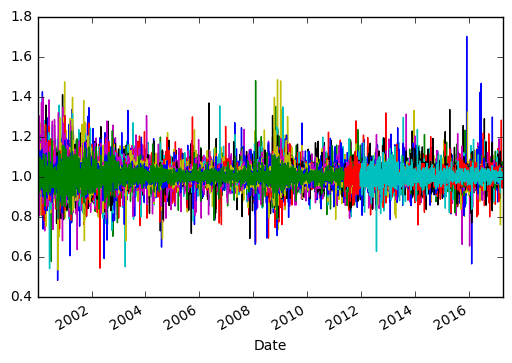

In [1048]:
tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'FB', 'INTC', 'TSM', 'ORCL', 'CSCO', 'IBM', 'SAP', 'QCOM', 'DCM', 'TXN', 'AVGO', 'ADBE', 'CRM', 'BIDU', 'ITW', 'YHOO', 'ADP', 'HPE', 'INFY', 'NVDA', 'NXPI', 'ATVI', 'NOK', 'VMW', 'AMAT', 'CTSH', 'ETN', 'INTU', 'HPQ', 'LNKD', 'EA', 'WIT', 'FISV', 'CERN', 'OMC', 'ADI', 'ULTI', 'WDAY', 'MU', 'WDC', 'LRCX', 'ADSK', 'SYMC', 'SWKS', 'LLTC', 'PANW', 'RHT', 'CA', 'VRSK', 'CHKP', 'NOW', 'CTXS', 'XLNX', 'MCHP', 'TWTR', 'MSI', 'LLL', 'MXIM', 'PNR', 'BKFS', 'STX', 'DOV', 'ZNGA', 'NTAP', 'ASX', 'TRIP', 'JNPR', 'IPG', 'SNPS', 'DOX', 'CUDA', 'MBLY', 'N', 'FFIV', 'VRSN', 'SPLK', 'ANSS', 'OTEX', 'AER', 'FLEX', 'CDNS', 'SABR', 'STM', 'QRVO', 'CSC', 'YNDX', 'URI', 'WUBA', 'MIDD', 'MRVL', 'SSNC', 'ASML', 'JKHY', 'FDS', 'TYL', 'TEAM', 'COMM', 'TSLA']

start_date = datetime(2000, 1, 1)
end_date = datetime(2017, 3, 31)

daily_opens_df = pd.DataFrame({ticker: pdr.get_data_yahoo(ticker, start_date, end_date)["Adj Close"] for ticker in tickers})
daily_returns_df = daily_opens_df / daily_opens_df.shift(1)
daily_returns_df.plot(legend=False)

## Features

### Calculating Daily Zscores

Goes through each month in the dataset. For each month, calculates the cumulative returns through the month and the zscore of the returns across the market for the given day. 

In [1049]:
daily_zscores = []
monthly_returns = []
for month_start in pd.date_range(start=start_date, end=end_date, freq='MS'):
    month_end = end_of_month(month_start)
    curr_daily_df = daily_returns_df.loc[month_start:month_end]
    cum_returns_daily_df = curr_daily_df.apply(lambda x: x.cumsum())
    monthly_returns.append(cum_returns_daily_df.tail(1))
    daily_zscores.append(cum_returns_daily_df.apply(zscore, axis=1))
daily_zscores_df = pd.concat(daily_zscores)
monthly_returns_df = pd.concat(monthly_returns)

/Users/kevin/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/kevin/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


### Calculating Monthly Zscores

For each month, take a cumulative sum of the returns for a given ticker over the previous 12 months and compute the zscore of the returns across the market for that month. 

In [1050]:
monthly_zscores = {}

for query_month in pd.date_range(start=increment_months(start_date, 11), end=end_date, freq='M'):
    start_month = end_of_month(decrement_months(query_month, 11))
    curr_monthly_df = monthly_returns_df.loc[start_month:query_month]
    cum_returns_monthly_df = curr_monthly_df.apply(lambda x: x.cumsum())
    monthly_zscores[query_month] = cum_returns_monthly_df.apply(zscore, axis=1)

    
monthly_zscores_df = pd.concat(monthly_zscores)

### Creating Features Dataframe

Each sample point has 32 features: 20 daily returns zscores and 12 monthly returns zscores. Each label is either 0 or 1: 1 if the ticker produces a return greater than the median the following month and 0 otherwise. Thus, we have a datapoint for a given month and stock ticker. 

#### Training Features

In [1051]:
train_features = []
train_labels = []

for query_month in pd.date_range(start=increment_months(start_date, 12), end=pd.to_datetime('2014-12-31'), freq='M'):
    query_month_start = beginning_of_month(query_month)
    next_month = increment_months(query_month, 1)
    
    next_month_returns_df = monthly_returns_df.loc[beginning_of_month(next_month):end_of_month(next_month)]
    next_median_return = np.nanmedian(next_month_returns_df)

    curr_daily_zscores_df = daily_zscores_df.loc[query_month_start:query_month]
    curr_monthly_zscores_df = monthly_zscores_df.loc[query_month]
    
    train_features.append(pd.concat([curr_monthly_zscores_df, curr_daily_zscores_df.head(20)], ignore_index=True))
    train_labels.append(monthly_returns_df.loc[beginning_of_month(query_month):query_month].apply(lambda x: x > curr_median_return))

train_features_df = pd.concat(train_features, axis=1)
train_labels_df = pd.concat(train_labels).astype(int)

train_features = np.nan_to_num(train_features_df.as_matrix()).T
train_labels = train_labels_df.as_matrix().reshape(train_features.shape[0])

#### Testing Features

In [1052]:
test_features = []
test_labels = []

for query_month in pd.date_range(start=pd.to_datetime('2015-01-01'), end=end_date, freq='M'):
    query_month_start = beginning_of_month(query_month)
    next_month = increment_months(query_month, 1)
    curr_daily_zscores_df = daily_zscores_df.loc[query_month_start:query_month]
    curr_monthly_zscores_df = monthly_zscores_df.loc[query_month]
    next_month_returns_df = monthly_returns_df.loc[beginning_of_month(next_month):end_of_month(next_month)]
    next_median_return = np.nanmedian(next_month_returns_df)

    curr_daily_zscores_df = curr_daily_zscores_df.rename(columns={ticker: (ticker, query_month) for ticker in tickers})
    curr_monthly_zscores_df = curr_monthly_zscores_df.rename(columns={ticker: (ticker, query_month) for ticker in tickers})

    test_features.append(pd.concat([curr_monthly_zscores_df, curr_daily_zscores_df.head(20)], ignore_index=True))
    test_labels.append(monthly_returns_df.loc[beginning_of_month(query_month):query_month].apply(lambda x: x > curr_median_return))

test_features_df = pd.concat(test_features, axis=1)
test_labels_df = pd.concat(test_labels).astype(int)

test_features = np.nan_to_num(test_features_df.as_matrix()).T
test_labels = test_labels_df.as_matrix().reshape(test_features.shape[0])

/Users/kevin/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


## Training

### Neural Net

In [1053]:
model_nn = neural_network.MLPClassifier(max_iter=500)
train_model(model_nn, train_features, train_labels, test_features, test_labels)

Train Accuracy: 0.9589169000933707
Test Accuracy: 0.9600580973129993


### Random Forest

In [1054]:
model_rf = ensemble.RandomForestClassifier()
train_model(model_rf, train_features, train_labels, test_features, test_labels)

Train Accuracy: 0.9926470588235294
Test Accuracy: 0.9604212055192447


### Logistic Regression

In [1055]:
model_lr = linear_model.LogisticRegression()
train_model(model_lr, train_features, train_labels, test_features, test_labels)

Train Accuracy: 0.9572829131652661
Test Accuracy: 0.9615105301379812


## Backtesting

In [1056]:
num_tickers = len(tickers)
decile_count = num_tickers // 10

def predict_actions(model):
    actions = []
    for month in pd.date_range(start=pd.to_datetime('2015-1-1'), end=end_date, freq='MS'):
        month_opens_df = daily_opens_df.loc[month:end_of_month(month)].head(1)
        positive_return_prob = {}
        for ticker in tickers:
            positive_return_prob[ticker] = model.predict_proba(np.nan_to_num(test_features_df[ticker, end_of_month(month)].as_matrix().reshape(1, 32)))[0][1]
        next_month = end_of_month(increment_months(month, 1))
        df = pd.DataFrame({'date': next_month, 'ticker': list(pd.Series(positive_return_prob.keys())[0]), 'probs': list(positive_return_prob.values())})
        sorted_by_probs_df = df.sort_values('probs', ascending=False)
        top_decile_df = pd.DataFrame(sorted_by_probs_df.head(10))
        bottom_decile_df = pd.DataFrame(sorted_by_probs_df.tail(10))
        top_decile_df['action'] = 'BUY'
        bottom_decile_df['action'] = 'SELL'
        top_decile_df['price'] = top_decile_df.apply(lambda row: month_opens_df[row['ticker']], axis=1)
        bottom_decile_df['price'] = bottom_decile_df.apply(lambda row: month_opens_df[row['ticker']], axis=1)
        actions.append(bottom_decile_df[['date', 'ticker', 'price', 'action']])
        actions.append(top_decile_df[['date', 'ticker', 'price', 'action']])


    actions_df = pd.concat(actions)
    actions_df.set_index(['date'], inplace=True)
    return actions_df

nn_actions_df = predict_actions(model_nn)
lr_actions_df = predict_actions(model_lr)
rf_actions_df = predict_actions(model_rf)

In [1057]:
def portfolio_value(date, portfolio, month, capital):
    value = 0
    month_opens_df = daily_opens_df.loc[month:end_of_month(month)].head(1)
    for ticker, stock_count in portfolio.items():
        value += np.nan_to_num(month_opens_df.loc[date][ticker]) * stock_count
    return value + capital

def backtest(start_date, end_date, actions_df, capital, name='Backtest'):
    portfolio = {ticker: 0 for ticker in tickers}
    portfolio_values = {decrement_months(start_date, 1): capital}
    for month in pd.date_range(start=start_date, end=end_date, freq='MS'):
        for index, row in actions_df.loc[end_of_month(month)].iterrows():
            if row['action'] == 'BUY' and not np.isnan(row['price']):
                shares_to_buy = capital * 0.1 // row['price']
                capital -= shares_to_buy * row['price']
                portfolio[row['ticker']] += shares_to_buy
            if row['action'] == 'SELL' and not np.isnan(row['price']):
                capital += portfolio[row['ticker']] * row['price']
                portfolio[row['ticker']] = 0
        t = str(daily_opens_df.loc[month:end_of_month(month)].head(1).index[0])[:10]
        portfolio_values[month] = portfolio_value(t, portfolio, month, capital)
    df = pd.DataFrame.from_dict(portfolio_values, orient="index")
    df.rename(columns={0: name}, inplace=True)
    return df, portfolio

backtest_start_date = pd.to_datetime('2015-02-01')
backtest_end_date = pd.to_datetime('2017-02-28')

capital = 1000000

nn_portfolio_df, _ = backtest(backtest_start_date, backtest_end_date, nn_actions_df, capital, name="nn")
lr_portfolio_df, _ = backtest(backtest_start_date, backtest_end_date, lr_actions_df, capital, name="lr")
rf_portfolio_df, _ = backtest(backtest_start_date, backtest_end_date, rf_actions_df, capital, name="rf")

In [1058]:
spy = pdr.get_data_yahoo('SPY', backtest_start_date, backtest_end_date)['Adj Close']
buy_price = spy.head(1)[0]

capital = 1e6
shares = 1e6 / buy_price

spy_df = spy.apply(lambda x: x * shares)

month_start_spy = []
for month in pd.date_range(start=backtest_start_date, end=backtest_end_date, freq='MS'):
    month_start_spy.append(spy_df.loc[month:end_of_month(month)].head(1))
    
month_start_spy_df = pd.DataFrame(pd.concat(month_start_spy))

month_start_spy_df.index = month_start_spy_df.index.map(beginning_of_month)
month_start_spy_df.rename(columns={"Adj Close": "SPY"}, inplace=True)

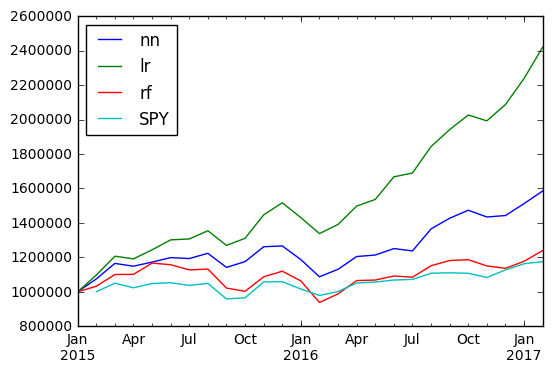

In [1059]:
pd.concat([nn_portfolio_df, lr_portfolio_df, rf_portfolio_df, month_start_spy_df], axis=1).plot()


## Observations

### Action Analysis

Let's take a look at a couple of the actions for various stocks

In [1060]:
view_actions('TSLA', nn_actions_df)

,ticker,price,action
date,,,
2015-04-30,TSLA,197.330002,BUY
2015-06-30,TSLA,226.029999,SELL
2015-07-31,TSLA,249.449997,BUY
2015-11-30,TSLA,239.880005,BUY
2015-12-31,TSLA,213.789993,BUY
2016-06-30,TSLA,241.800003,SELL
2016-10-31,TSLA,200.770004,BUY
2016-11-30,TSLA,213.699997,BUY
2017-02-28,TSLA,216.990005,BUY


In [1061]:
view_actions('AAPL', nn_actions_df)

,ticker,price,action
date,,,
2015-02-28,AAPL,104.704758,BUY
2016-05-31,AAPL,107.712919,SELL
2016-07-31,AAPL,97.008682,BUY
2016-10-31,AAPL,105.726441,BUY


In [1062]:
view_actions('WDC', nn_actions_df)

,ticker,price,action
date,,,
2015-04-30,WDC,101.346310,SELL
2015-07-31,WDC,90.981951,SELL
2015-10-31,WDC,75.820290,SELL
2016-12-31,WDC,56.479402,BUY


In [1063]:
view_actions('AMZN', nn_actions_df)

,ticker,price,action
date,,,
2015-12-31,AMZN,628.349976,BUY
2016-02-29,AMZN,636.989990,BUY
2016-04-30,AMZN,579.039978,BUY
2016-06-30,AMZN,683.849976,BUY
